<a href="https://colab.research.google.com/github/AmayaDes/Neuro-Symbolic_PCOS-Detection-FYP/blob/main/notebooks/01_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amayajayarathna","key":"626c928eb8783b512c0b23b3d9582d83"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d amayajayarathna/pcos-ultrasound-dataset-deduplicated-and-balanced

Dataset URL: https://www.kaggle.com/datasets/amayajayarathna/pcos-ultrasound-dataset-deduplicated-and-balanced
License(s): unknown
 89% 132M/148M [00:00<00:00, 1.37GB/s]
100% 148M/148M [00:00<00:00, 1.25GB/s]


In [8]:
!unzip pcos-ultrasound-dataset-deduplicated-and-balanced


Archive:  pcos-ultrasound-dataset-deduplicated-and-balanced.zip
  inflating: organized_data/Normal/Dataset-1_data_test_img_0_7.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img1.jpeg  
  inflating: organized_data/Normal/Dataset-1_data_train_img2.png  
  inflating: organized_data/Normal/Dataset-1_data_train_img3.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img4.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_0.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_100.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_1012.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_1015.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_1020.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_1022.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_1027.jpg  
  inflating: organized_data/Normal/Dataset-1_data_train_img_0_103.jpg  
  inflating: organi

In [9]:
!ls


organized_data					       sample_data
pcos-ultrasound-dataset-deduplicated-and-balanced.zip


In [10]:
!ls organized_data


Normal	PCOS


PCOS DATA SPLITTING PIPELINE
  Removing old organized dataset...
 Dataset found at: /content/organized_data

LOADING IMAGES

 PCOS folder: 1660 images


Loading PCOS: 100%|██████████| 1660/1660 [00:00<00:00, 163466.88it/s]


 Normal folder: 2316 images


Loading Normal: 100%|██████████| 2316/2316 [00:00<00:00, 231677.55it/s]



 Total images loaded: 3976
   PCOS:   1660 (41.8%)
   Normal: 2316 (58.2%)
   Ratio:  0.72:1 (PCOS:Normal)

STEP 2: SPLITTING DATA (Stratified)

 Split ratios: Train=70%, Val=15%, Test=15%

 Split complete:
   Train: 2783 images
   Val:   596 images
   Test:  597 images

STEP 3: CREATING DIRECTORY STRUCTURE
 Created: /content/organized_split/train/pcos
 Created: /content/organized_split/train/normal
 Created: /content/organized_split/val/pcos
 Created: /content/organized_split/val/normal
 Created: /content/organized_split/test/pcos
 Created: /content/organized_split/test/normal

STEP 4: COPYING FILES

 Copying train files...


  train: 100%|██████████| 2783/2783 [00:01<00:00, 2044.82it/s]



 Copying val files...


  val: 100%|██████████| 596/596 [00:00<00:00, 997.72it/s] 



 Copying test files...


  test: 100%|██████████| 597/597 [00:00<00:00, 1357.93it/s]



STEP 5: SAVING METADATA
 Saved: /content/organized_split/train_metadata.csv
 Saved: /content/organized_split/val_metadata.csv
 Saved: /content/organized_split/test_metadata.csv

STEP 6: GENERATING VISUALIZATIONS
 Saved: /content/organized_split/split_distribution.png


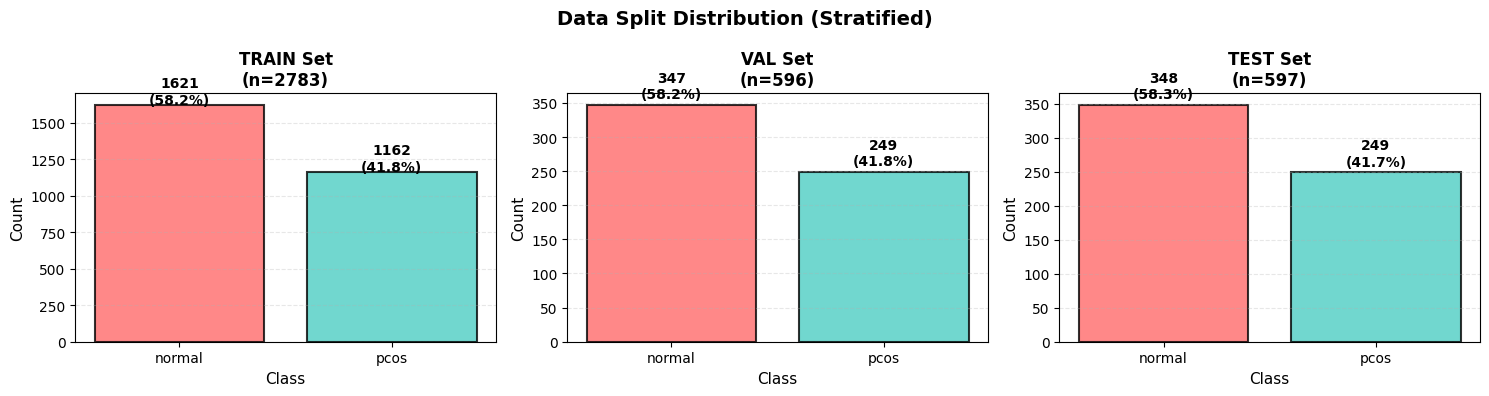

 Saved: /content/organized_split/sample_images.png


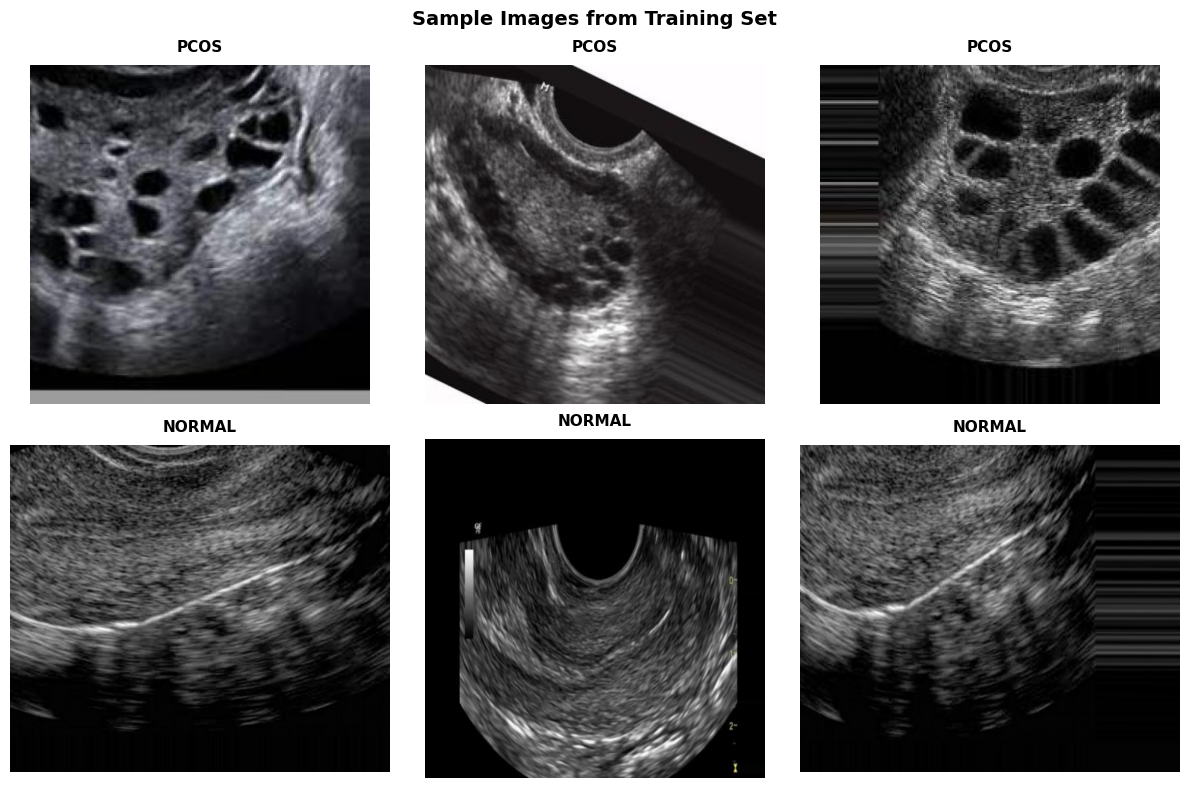


FINAL Summery

 Output Location: /content/organized_split

 Class Distribution:
Split            PCOS   Normal    Total      Ratio
-------------------------------------------------------
Train            1162     1621     2783     0.72:1
Val               249      347      596     0.72:1
Test              249      348      597     0.72:1

  Class Weights (for training):
   Normal (class 0): 0.858
   PCOS (class 1):   1.198

 Generated Files:
   train/ (2783 images)
   val/ (596 images)
   test/ (597 images)
   train_metadata.csv
   val_metadata.csv
   test_metadata.csv
   split_distribution.png
   sample_images.png

 Usage in Training:
   class_weight = {0: np.float64(0.8584207279457126), 1: np.float64(1.1975043029259897)}
   model.fit(train_data, class_weight=class_weight)

 PIPELINE COMPLETE!


In [14]:
"""
PCOS Data Splitting Pipeline for Kaggle
Works with organized_data folder (PCOS and Normal subdirectories)
Creates train/val/test splits with proper stratification and class weights
"""

import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# CONFIGURATION FOR KAGGLE
# ========================

BASE_DIR = "/content/organized_data"
OUTPUT_DIR = "/content/organized_split"

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print("="*70)
print("PCOS DATA SPLITTING PIPELINE")
print("="*70)

# Clean old organized data if exists
if os.path.exists(OUTPUT_DIR):
    print("  Removing old organized dataset...")
    shutil.rmtree(OUTPUT_DIR)

# Verify dataset exists
if not os.path.exists(BASE_DIR):
    raise Exception(f" Dataset not found at {BASE_DIR}")

print(f" Dataset found at: {BASE_DIR}")

# ========================
# PCOSDataLoader
# ========================

class PCOSDataLoader:
    """
    Load images from organized_data folder
    Expects structure: organized_data/PCOS/ and organized_data/Normal/
    """

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.pcos_dir = os.path.join(base_dir, "PCOS")
        self.normal_dir = os.path.join(base_dir, "Normal")
        self.image_data = []

        # Verify directories exist
        if not os.path.exists(self.pcos_dir):
            raise FileNotFoundError(f" PCOS directory not found: {self.pcos_dir}")
        if not os.path.exists(self.normal_dir):
            raise FileNotFoundError(f" Normal directory not found: {self.normal_dir}")

    def load_images(self):
        """Load all images from PCOS and Normal folders"""

        print("\n" + "="*70)
        print("LOADING IMAGES")
        print("="*70)

        # Load PCOS images
        pcos_images = [f for f in os.listdir(self.pcos_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"\n PCOS folder: {len(pcos_images)} images")

        for img in tqdm(pcos_images, desc="Loading PCOS"):
            self.image_data.append({
                'filename': img,
                'label': 1,  # PCOS = 1
                'label_name': 'pcos',
                'source_path': os.path.join(self.pcos_dir, img)
            })

        # Load Normal images
        normal_images = [f for f in os.listdir(self.normal_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f" Normal folder: {len(normal_images)} images")

        for img in tqdm(normal_images, desc="Loading Normal"):
            self.image_data.append({
                'filename': img,
                'label': 0,  # Normal = 0
                'label_name': 'normal',
                'source_path': os.path.join(self.normal_dir, img)
            })

        total = len(self.image_data)
        pcos_pct = (len(pcos_images) / total) * 100
        normal_pct = (len(normal_images) / total) * 100

        print(f"\n Total images loaded: {total}")
        print(f"   PCOS:   {len(pcos_images)} ({pcos_pct:.1f}%)")
        print(f"   Normal: {len(normal_images)} ({normal_pct:.1f}%)")
        print(f"   Ratio:  {len(pcos_images)/len(normal_images):.2f}:1 (PCOS:Normal)")

        return self

    def get_dataframe(self):
        """Return DataFrame with all image metadata"""
        return pd.DataFrame(self.image_data)


# ========================
# DataSplitter
# ========================

class DataSplitter:
    """
    Split data into train/val/test with stratification
    Maintains class balance across all splits
    """

    def __init__(self, df, train=0.7, val=0.15, test=0.15):
        self.df = df
        self.train = train
        self.val = val
        self.test = test

        # Verify ratios sum to 1.0
        total = train + val + test
        if not np.isclose(total, 1.0):
            raise ValueError(f"Split ratios must sum to 1.0, got {total}")

    def split(self):
        """Perform stratified train/val/test split"""

        print("\n" + "="*70)
        print("STEP 2: SPLITTING DATA (Stratified)")
        print("="*70)
        print(f"\n Split ratios: Train={self.train*100:.0f}%, Val={self.val*100:.0f}%, Test={self.test*100:.0f}%")

        # First split: train vs (val + test)
        train_df, temp_df = train_test_split(
            self.df,
            test_size=(self.val + self.test),
            stratify=self.df['label'],
            random_state=42
        )

        # Second split: val vs test
        val_ratio = self.val / (self.val + self.test)
        val_df, test_df = train_test_split(
            temp_df,
            test_size=(1 - val_ratio),
            stratify=temp_df['label'],
            random_state=42
        )

        # Print split statistics
        print(f"\n Split complete:")
        print(f"   Train: {len(train_df)} images")
        print(f"   Val:   {len(val_df)} images")
        print(f"   Test:  {len(test_df)} images")

        return train_df, val_df, test_df


# ========================
# DataOrganizer
# ========================

class DataOrganizer:
    """
    Organize split data into folder structure and generate reports
    """

    def __init__(self, out_dir, train_df, val_df, test_df):
        self.out_dir = out_dir
        self.splits = {
            'train': train_df,
            'val': val_df,
            'test': test_df
        }

    def create_structure(self):
        """Create output directory structure"""
        print("\n" + "="*70)
        print("STEP 3: CREATING DIRECTORY STRUCTURE")
        print("="*70)

        for split in ['train', 'val', 'test']:
            for cls in ['pcos', 'normal']:
                path = os.path.join(self.out_dir, split, cls)
                os.makedirs(path, exist_ok=True)
                print(f" Created: {path}")

    def copy_files(self):
        """Copy files to organized structure"""
        print("\n" + "="*70)
        print("STEP 4: COPYING FILES")
        print("="*70)

        for split, df in self.splits.items():
            print(f"\n Copying {split} files...")
            for _, row in tqdm(df.iterrows(), total=len(df), desc=f"  {split}"):
                dst = os.path.join(self.out_dir, split, row['label_name'], row['filename'])
                shutil.copy(row['source_path'], dst)

    def save_metadata(self):
        """Save metadata CSV files for each split"""
        print("\n" + "="*70)
        print("STEP 5: SAVING METADATA")
        print("="*70)

        for split, df in self.splits.items():
            df = df.copy()
            df['image_path'] = df.apply(
                lambda r: os.path.join(self.out_dir, split, r['label_name'], r['filename']),
                axis=1
            )
            csv_path = os.path.join(self.out_dir, f"{split}_metadata.csv")
            df.to_csv(csv_path, index=False)
            print(f" Saved: {csv_path}")

    def compute_class_weights(self):
        """Compute class weights for handling imbalance"""
        train_df = self.splits['train']
        labels = train_df['label'].values

        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(labels),
            y=labels
        )

        class_weight_dict = {
            0: class_weights[0],  # Normal
            1: class_weights[1]   # PCOS
        }

        return class_weight_dict

    def plot_split_distribution(self):
        """Visualize class distribution across splits"""
        print("\n" + "="*70)
        print("STEP 6: GENERATING VISUALIZATIONS")
        print("="*70)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        for idx, (split, df) in enumerate(self.splits.items()):
            counts = df['label_name'].value_counts()
            colors = ['#ff6b6b', '#4ecdc4']

            axes[idx].bar(counts.index, counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
            axes[idx].set_title(f'{split.upper()} Set\n(n={len(df)})', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Count', fontsize=11)
            axes[idx].set_xlabel('Class', fontsize=11)
            axes[idx].grid(axis='y', alpha=0.3, linestyle='--')

            # Add value labels on bars
            for i, v in enumerate(counts.values):
                pct = (v / len(df)) * 100
                axes[idx].text(i, v + 10, f'{v}\n({pct:.1f}%)',
                              ha='center', fontweight='bold', fontsize=10)

        plt.suptitle('Data Split Distribution (Stratified)', fontsize=14, fontweight='bold')
        plt.tight_layout()

        save_path = os.path.join(self.out_dir, 'split_distribution.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f" Saved: {save_path}")
        plt.show()

    def plot_sample_images(self, n_samples=3):
        """Display sample images from each class"""
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))

        train_df = self.splits['train']

        for row_idx, label_name in enumerate(['pcos', 'normal']):
            samples = train_df[train_df['label_name'] == label_name].sample(
                n=n_samples, random_state=42
            )

            for col_idx, (_, sample) in enumerate(samples.iterrows()):
                img_path = os.path.join(self.out_dir, 'train', label_name, sample['filename'])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[row_idx, col_idx].imshow(img)
                axes[row_idx, col_idx].axis('off')
                axes[row_idx, col_idx].set_title(
                    f'{label_name.upper()}',
                    fontsize=11,
                    fontweight='bold',
                    pad=10
                )
                axes[row_idx, col_idx].spines['top'].set_visible(False)
                axes[row_idx, col_idx].spines['right'].set_visible(False)
                axes[row_idx, col_idx].spines['bottom'].set_visible(False)
                axes[row_idx, col_idx].spines['left'].set_visible(False)

        plt.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')
        plt.tight_layout()

        save_path = os.path.join(self.out_dir, 'sample_images.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f" Saved: {save_path}")
        plt.show()

    def generate_summary_report(self, class_weights):
        """Generate comprehensive summary"""
        print("\n" + "="*70)
        print("FINAL Summery")
        print("="*70)

        print(f"\n Output Location: {self.out_dir}")

        print(f"\n Class Distribution:")
        print(f"{'Split':<12} {'PCOS':>8} {'Normal':>8} {'Total':>8} {'Ratio':>10}")
        print("-" * 55)

        for split_name, split_df in self.splits.items():
            pcos_count = len(split_df[split_df['label'] == 1])
            normal_count = len(split_df[split_df['label'] == 0])
            total = len(split_df)
            ratio = f"{pcos_count/normal_count:.2f}:1" if normal_count > 0 else "N/A"

            print(f"{split_name.capitalize():<12} {pcos_count:>8} {normal_count:>8} {total:>8} {ratio:>10}")

        print(f"\n  Class Weights (for training):")
        print(f"   Normal (class 0): {class_weights[0]:.3f}")
        print(f"   PCOS (class 1):   {class_weights[1]:.3f}")

        print(f"\n Generated Files:")
        print(f"   train/ ({len(self.splits['train'])} images)")
        print(f"   val/ ({len(self.splits['val'])} images)")
        print(f"   test/ ({len(self.splits['test'])} images)")
        print(f"   train_metadata.csv")
        print(f"   val_metadata.csv")
        print(f"   test_metadata.csv")
        print(f"   split_distribution.png")
        print(f"   sample_images.png")

        print(f"\n Usage in Training:")
        print(f"   class_weight = {class_weights}")
        print(f"   model.fit(train_data, class_weight=class_weight)")


# ========================
# RUN PIPELINE
# ========================

try:
    # Load images
    loader = PCOSDataLoader(BASE_DIR).load_images()
    df = loader.get_dataframe()

    # Split data
    splitter = DataSplitter(df, train=TRAIN_RATIO, val=VAL_RATIO, test=TEST_RATIO)
    train_df, val_df, test_df = splitter.split()

    # Organize and generate reports
    organizer = DataOrganizer(OUTPUT_DIR, train_df, val_df, test_df)
    organizer.create_structure()
    organizer.copy_files()
    organizer.save_metadata()

    # Compute class weights
    class_weights = organizer.compute_class_weights()

    # Generate visualizations
    organizer.plot_split_distribution()
    organizer.plot_sample_images()

    # Final summary
    organizer.generate_summary_report(class_weights)

    print("\n" + "="*70)
    print(" PIPELINE COMPLETE!")
    print("="*70)

except Exception as e:
    print(f"\n ERROR: {str(e)}")
    raise

In [15]:
!zip -r organized_split.zip /content/organized_split/


  adding: content/organized_split/ (stored 0%)
  adding: content/organized_split/val/ (stored 0%)
  adding: content/organized_split/val/pcos/ (stored 0%)
  adding: content/organized_split/val/pcos/Dataset-2_roboflow_train_img_0_1257_jpg.rf.31de044b8602865ec60d249a872fb756.jpg (deflated 4%)
  adding: content/organized_split/val/pcos/Dataset-2_roboflow_valid_img_0_8205_jpg.rf.80c6853c8a399e637e83aae3cfa604c0.jpg (deflated 3%)
  adding: content/organized_split/val/pcos/Dataset-2_roboflow_train_img_0_9546_jpg.rf.39d921ccece1c351fca418349ffe82b1.jpg (deflated 2%)
  adding: content/organized_split/val/pcos/Dataset-2_roboflow_train_img_0_6740_jpg.rf.79a726763a5f56caf1fdf63101b535d7.jpg (deflated 5%)
  adding: content/organized_split/val/pcos/Dataset-2_roboflow_train_img_0_3799_jpg.rf.88a95f8e2fa4638ea586d90e49690f94.jpg (deflated 2%)
  adding: content/organized_split/val/pcos/Dataset-1_data_train_img_0_2380.jpg (deflated 2%)
  adding: content/organized_split/val/pcos/Dataset-1_data_train_img_